<a href="https://colab.research.google.com/github/samira-shirdhankar/Data-analyst/blob/main/Chicago_Bike_Sharing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
# Import libraries
import matplotlib
#from matplotlib import animation
import matplotlib.pyplot as plt
from matplotlib import rcParams
#rom itertools import count
import seaborn as sns
import numpy as np
import plotly.express as px
import pandas as pd


In [7]:
#open a google sheet authorisation
from google.colab import auth
auth.authenticate_user()

import gspread
from oauth2client.client import GoogleCredentials
 
gc = gspread.authorize(GoogleCredentials.get_application_default())

In [8]:
# Import PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive

# Authenticate and create the PyDrive client.
# This only needs to be done once per notebook.

gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [3]:
df = pd.DataFrame()

All data files are uploaded on drive in a seperateed folder.

In [9]:
# Search query reference:
# https://developers.google.com/drive/v2/web/search-parameters
listed = drive.ListFile({'q': "'(folder_key)' in parents and mimeType= 'text/csv'"}).GetList()
#print(listed)
for file in listed:
  downloaded = drive.CreateFile({'id':file['id']}) 
  downloaded.GetContentFile('Filename.csv')  
  df = df.append(pd.read_csv('Filename.csv'))
  print(len(df))

631226
1387373
2191725
3014135
3743730
4275363
4612593
4841089
4890711
4987545
5119118
5378834


In [10]:
# convert the 'Date' column to datetime format
df['started_at']= pd.to_datetime(df['started_at'], errors='coerce')
df['ended_at']= pd.to_datetime(df['ended_at'], errors='coerce')
 
# Check the format of 'Date' column
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5378834 entries, 0 to 259715
Data columns (total 13 columns):
 #   Column              Dtype         
---  ------              -----         
 0   ride_id             object        
 1   rideable_type       object        
 2   started_at          datetime64[ns]
 3   ended_at            datetime64[ns]
 4   start_station_name  object        
 5   start_station_id    object        
 6   end_station_name    object        
 7   end_station_id      object        
 8   start_lat           float64       
 9   start_lng           float64       
 10  end_lat             float64       
 11  end_lng             float64       
 12  member_casual       object        
dtypes: datetime64[ns](2), float64(4), object(7)
memory usage: 574.5+ MB


In [11]:
# Get month number and name column
df['month']= df['started_at'].dt.month
df['month_name'] = df['started_at'].dt.month_name()

In [12]:
# Get week number column
df['week']= df['started_at'].dt.isocalendar().week

In [13]:
# Get start of week
df['week_start'] = df['started_at'].dt.to_period('W').apply(lambda r: r.start_time).dt.date

In [14]:
# Get day of week

df['day_of_week']= df['started_at'].dt.day_name()

In [15]:
# Get hour
df['hour_of_day'] = df['started_at'].dt.hour

In [ ]:
# Get total time duration for each ride
df['total_duration_hr']= df['ended_at'] - df['started_at']
df['total_duration_hr']= df['total_duration_hr']/np.timedelta64(4,'h')
df['total_duration_hr']= df['total_duration_hr'].round(decimals = 2)


df.tail()

In [17]:
# Delete rows where total ride duration is negative
neg_rides_time = df[df['total_duration_hr'] <= 0 ].index

df.drop(neg_rides_time, inplace = True)

In [18]:
# Df of casuals and members

group= df.groupby('member_casual')

#assign variable to casual and member group
group_casual_df= pd.DataFrame(group.get_group('casual'))
group_member_df= pd.DataFrame(group.get_group('member'))

In [ ]:
df.head(10)

Q. Members and casuals, compare total rides and total time duration among them

Number of rides by members are more than casuals by 8% but difference of total time duration of casuals are more than 33% than members.
Total time differrence between casuals and members is 1,65,797 hours in whole year.So there is an opportunity to convert casuals into members.

In [19]:
# Get total count of member and casual rides
mem_cas_count = df.groupby(['member_casual']).size()
mem_cas_count

member_casual
casual    2176447
member    2540303
dtype: int64

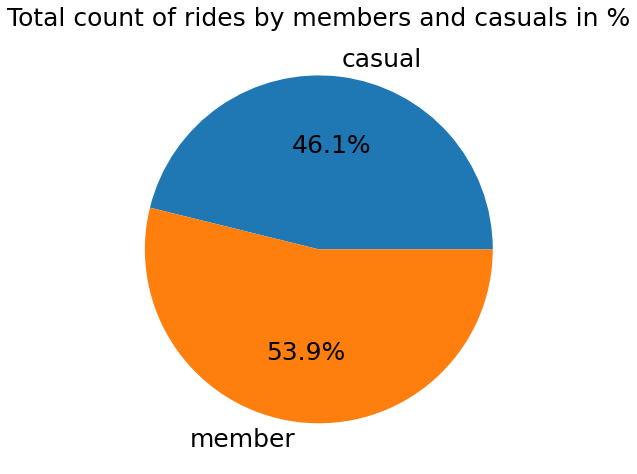

<Figure size 432x288 with 0 Axes>

In [20]:
# Plot  total count of member and casual rides 
plt.figure(figsize = (12,8)) 
mem_cas_count.plot(kind = "pie", autopct='%1.1f%%', fontsize = 25);

#modify individual font size of title
plt.title('Total count of rides by members and casuals in %', fontsize=25)
plt.ylabel(' ');

plt.figure();

In [21]:
# total ride time duration of members and casuals 
mem_cas_time= df.groupby(['member_casual'])['total_duration_hr'].sum()
mem_cas_time

member_casual
casual    300574.029999
member    150546.979999
Name: total_duration_hr, dtype: float64

<Figure size 432x288 with 0 Axes>

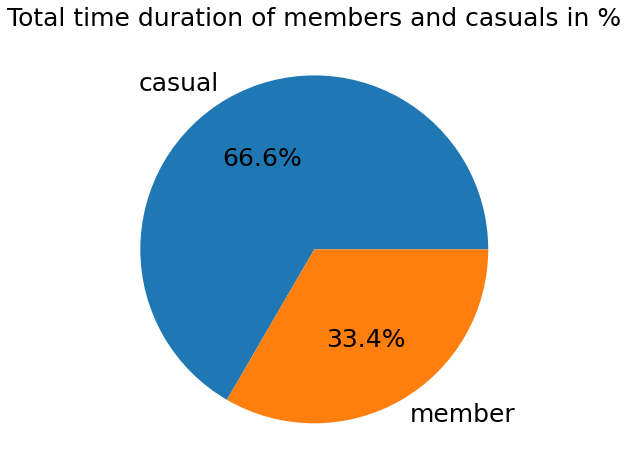

<Figure size 432x288 with 0 Axes>

In [ ]:
# Plot total time duration of members and casuals 
plt.figure(figsize = (12,8))
mem_cas_time.plot(kind = "pie",subplots = True, autopct='%1.1f%%', fontsize=25)

#modify individual font size of title
plt.title('Total time duration of members and casuals in %', fontsize=25)
plt.ylabel(' ')
plt.figure()

Q. Which stations are popular as a starting point and as an ending point among members and casuals?

This 25 stations are popular among members and casuals.

Streeter Dr & Grand Ave

Millennium Park	casual

Michigan Ave & Oak St

Clark St & Elm St

Wells St & Concord Ln

Shedd Aquarium

Kingsbury St & Kinzie St

Theater on the Lake

Lake Shore Dr & Monroe St

Wells St & Elm St

Wells St & Concord Ln

Dearborn St & Erie St

Wells St & Huron St

St. Clair St & Erie St

Broadway & Barry Ave

Clark St & Lincoln Ave

Indiana Ave & Roosevelt Rd

Wells St & Elm St

Clark St & Elm St

Clark St & Armitage Ave

Clark St & Lincoln Ave

Clark St & Armitage Ave

Desplaines St & Kinzie St

Wabash Ave & Grand Ave

Streeter Dr & Grand Ave



In [ ]:
# Total number of rides from each station member and casual riders
ststation_count = pd.DataFrame(df.groupby(['member_casual','start_station_name'],as_index =False).size()).sort_values(by=['start_station_name'], ascending=False)

# percentage
#ststation_count['percent'] = round((ststation_count['size'] / (ststation_count['size'].sum())) * 100, 2)

ststation_count.head(10)

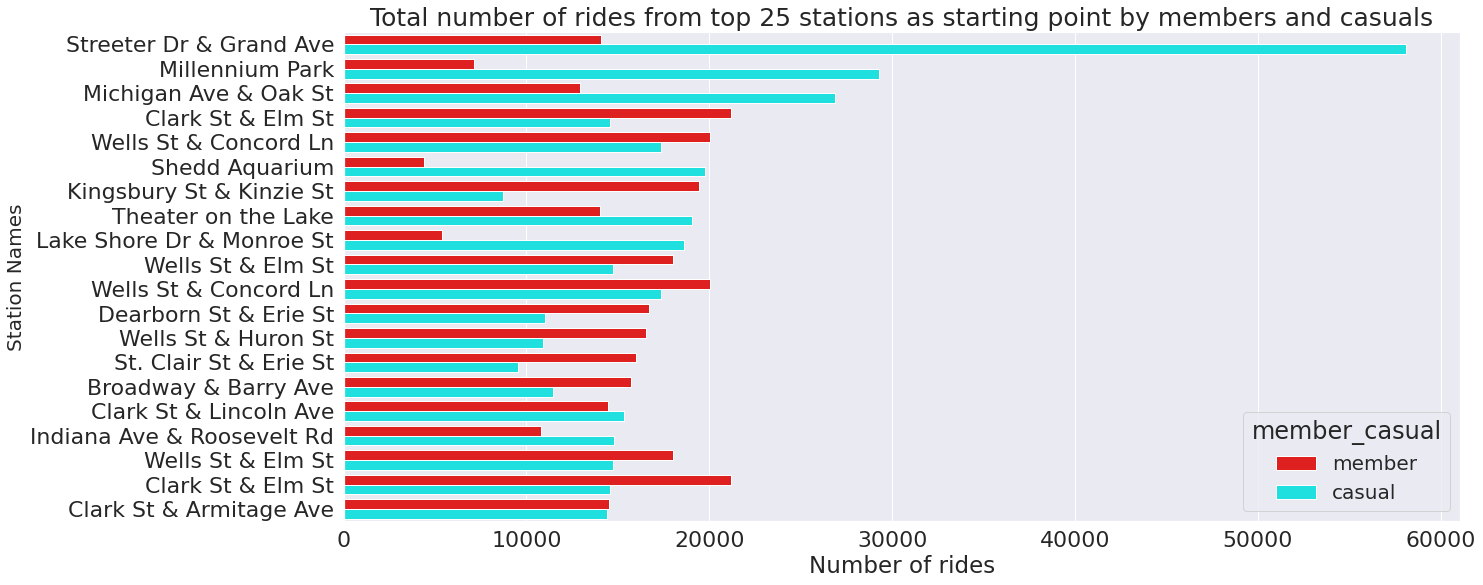

In [ ]:
# Plot total number of rides from each station as a starting point by member and casual riders
plt.figure(figsize = (20,9)) 
sns.barplot(x= 'size' , y = "start_station_name", hue="member_casual",data = ststation_count , 
            order= ststation_count.sort_values(by=['size'],ascending = False).start_station_name.head(20),
            palette = ['red','cyan'])

#modify individual font size of elements
plt.legend(title='member_casual', fontsize=20)
plt.ylabel('Station Names', fontsize=20);
plt.xlabel('Number of rides', fontsize=23);
plt.title("Total number of rides from top 25 stations as starting point by members and casuals", fontsize=25)
#plt.xticks(rotation=90)
plt.show()

In [ ]:
# Total rides from each station as an ending point by member and casual riders
endstation_count = pd.DataFrame(df.groupby(['member_casual','end_station_name'],as_index =False).size()).sort_values(by=['end_station_name'], ascending=False)

# percentage
#ndstation_count['percent'] = round((endstation_count['size'] / (endstation_count['size'].sum())) * 100, 2)

endstation_count.head(10)

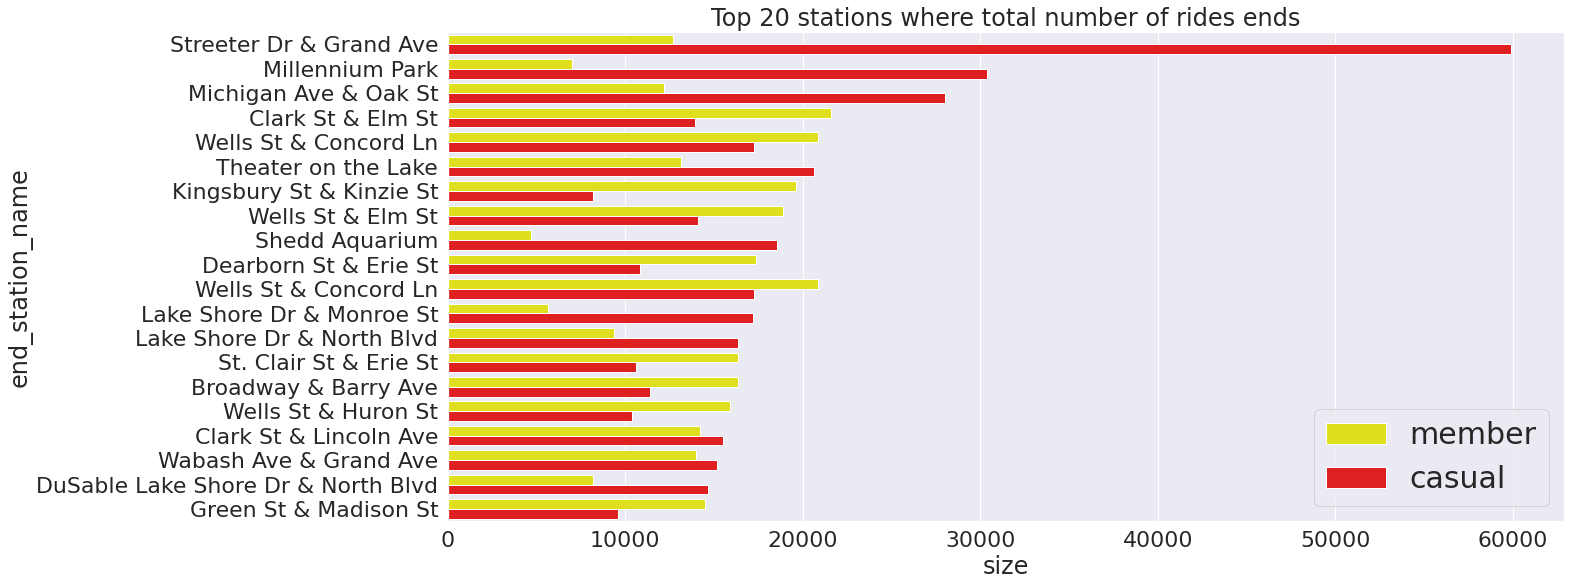

In [ ]:
# Plot Total number of rides end at stations 
plt.figure(figsize = (20,9)) 
sns.barplot(x= "size", y = "end_station_name", hue="member_casual",data = endstation_count ,
            order= endstation_count.sort_values(by=['size'],ascending = False).end_station_name.head(20),
            palette = ['yellow', 'red'])
plt.title("Top 20 stations where total number of rides ends")
plt.legend(fontsize=30)

plt.show()

In [ ]:
# Change name of the column to merge the dataframes
ststation_count.rename(columns = {'start_station_name':'station_names', 'size': 'st_ride_count', 'percent':'st_count_percent'}, inplace = True)
endstation_count.rename(columns = {'end_station_name':'station_names', 'size': 'end_ride_count', 'percent':'end_count_percent'}, inplace = True)

In [ ]:
# Merge start and end stations total count
merge_stations_count = pd.merge(ststation_count,endstation_count, on=['station_names','member_casual'], how='inner').sort_values(by=['st_ride_count','end_ride_count'],ascending = False)
merge_stations_count.head(15) 

Q. Which stations have more riding time duration than other stations?

List of top 20 station based on total time duration:

0                Streeter Dr & Grand Ave

1                        Millennium Park

2                  Michigan Ave & Oak St

3              Lake Shore Dr & Monroe St

4                         Shedd Aquarium

5                         Dusable Harbor

6                    Theater on the Lake

7                 Michigan Ave & Lake St

8                    Buckingham Fountain

9             Indiana Ave & Roosevelt Rd

10          Michigan Ave & Washington St

11                 Michigan Ave & 8th St

12                Wabash Ave & Grand Ave

13     DuSable Lake Shore Dr & Monroe St

14            Lake Shore Dr & North Blvd

15                  New St & Illinois St

16                Wabash Ave & Wacker Pl

17              Fairbanks Ct & Grand Ave

18    DuSable Lake Shore Dr & North Blvd

19             Columbus Dr & Randolph St


In [ ]:
#Based on members or casuals rides duration, most popular start stations
ststation_time= pd.DataFrame(df.groupby(['member_casual','start_station_name'],as_index =False)['total_duration_hr'].sum())

# Sort count in descending order
ststation_time= ststation_time.sort_values(by='total_duration_hr', ascending=False)

ststation_time.head()

In [ ]:
# Plot Based on member or casual rides duration, most popular start stations
fig = px.bar(ststation_time.groupby('member_casual').get_group("casual").head(20), 
             y="total_duration_hr", x="start_station_name", 
             color="member_casual", 
             title = 'Top 20 start stations Based on casuals rides duration top 20 start stations',
             color_discrete_sequence =['red'],
             width=1200, height=500)

fig1 = px.bar(ststation_time.groupby('member_casual').get_group("member").head(20),
              y="total_duration_hr", x="start_station_name",
             color="member_casual", color_discrete_sequence = ['green'],
              title = 'Top 20 start stations based on members rides duration',
             width=1200, height=500)
fig.show()
fig1.show()

In [ ]:
#Based on member or casual rides, popular end stations
endstation_time= pd.DataFrame(df.groupby(['member_casual','end_station_name'],as_index =False)['total_duration_hr'].sum())

# Sort in descending order
endstation_time= endstation_time.sort_values(by='total_duration_hr', ascending=False)

endstation_time.head()

In [ ]:
# Plot based on member or casual rides, popular end stations
fig = px.bar(endstation_time.groupby('member_casual').get_group("casual").head(20), y="total_duration_hr", x="end_station_name",
             color="member_casual", color_discrete_sequence =['crimson'], title = 'Top 20 end stations based on casuals rides duration')

fig1 = px.bar(endstation_time.groupby('member_casual').get_group("member").head(20), y="total_duration_hr", x="end_station_name", 
              color="member_casual",color_discrete_sequence =['navy'], title = 'Top 20 end stations based on members rides duration')

fig.show()
fig1.show()


In [ ]:
# Change column name for merging 
ststation_time.rename(columns = {'start_station_name':'station_names', 'total_duration_hr': 'st_ride_duration', 'percent':'st_duration_percent'}, inplace = True)
endstation_time.rename(columns = {'end_station_name':'station_names', 'total_duration_hr': 'end_ride_duration', 'percent':'end_duration_percent'}, inplace = True)

In [ ]:
# Merge data of start and end stations total ride duration 
merge_stations_time = pd.merge(ststation_time,endstation_time, on=['station_names','member_casual'], how='inner').sort_values(by=['st_ride_duration','end_ride_duration'],ascending = False)
merge_stations_time.head(10) 

In [ ]:
# Merge stations count and total duration df
stations_count_time = pd.merge(merge_stations_count,merge_stations_time, on=['station_names','member_casual'],
                           how='inner').sort_values(by=['st_ride_duration','st_ride_count','end_ride_duration','end_ride_count'],ascending = False)
stations_count_time.hed(10) 

Q. Which bike types are more popular among members and casuals?

Around 57% of members and casuals prefer classic bikes for rides.
Among casual rides classic bikes used for 49.64% rides and 36.16% rides prefered electric bikes.

Eventhough total rides count of electric bike is more than docked bike, riders are using docked bike for longer duration than electric bikes. 

In [ ]:
# Total rides by each bike type group by member and casual riders
bikety_count = pd.DataFrame(df.groupby(['member_casual','rideable_type'],as_index =False).size().sort_values(by = 'rideable_type',ascending=False))

# Sort count in descending order
bikety_count = bikety_count.sort_values(by='size', ascending=False)

# percentage
#bikety_count['percent'] = round((groupby_bikety_count['size'] / (groupby_bikety_count['size'].sum())) * 100, 2)

bikety_count.head(6)

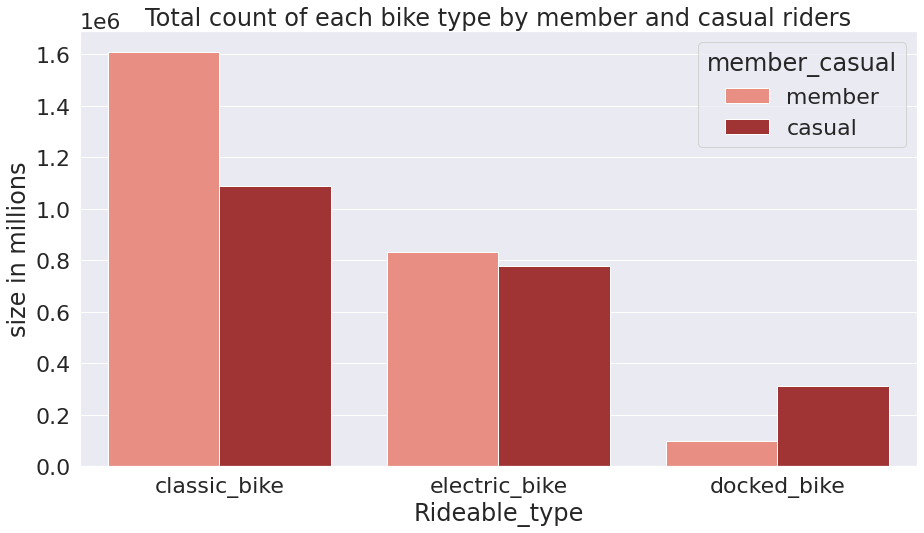

In [ ]:
# Plot total rides by each bike type group by member and casual riders
plt.figure(figsize = (15,8)) 
ax = sns.barplot(x="rideable_type", y = "size", hue="member_casual", data=bikety_count, palette = ['salmon','firebrick'])
plt.xlabel("Rideable_type")
plt.ylabel("size in millions")
plt.title("Total count of each bike type by member and casual riders")
plt.show()

In [ ]:
# Total rides time duration from each station group by member and casual riders
bikety_time= pd.DataFrame(df.groupby(['rideable_type','member_casual'],as_index =False)['total_duration_hr'].sum().sort_values(by = 'total_duration_hr',ascending=False))

bikety_time.head(10)

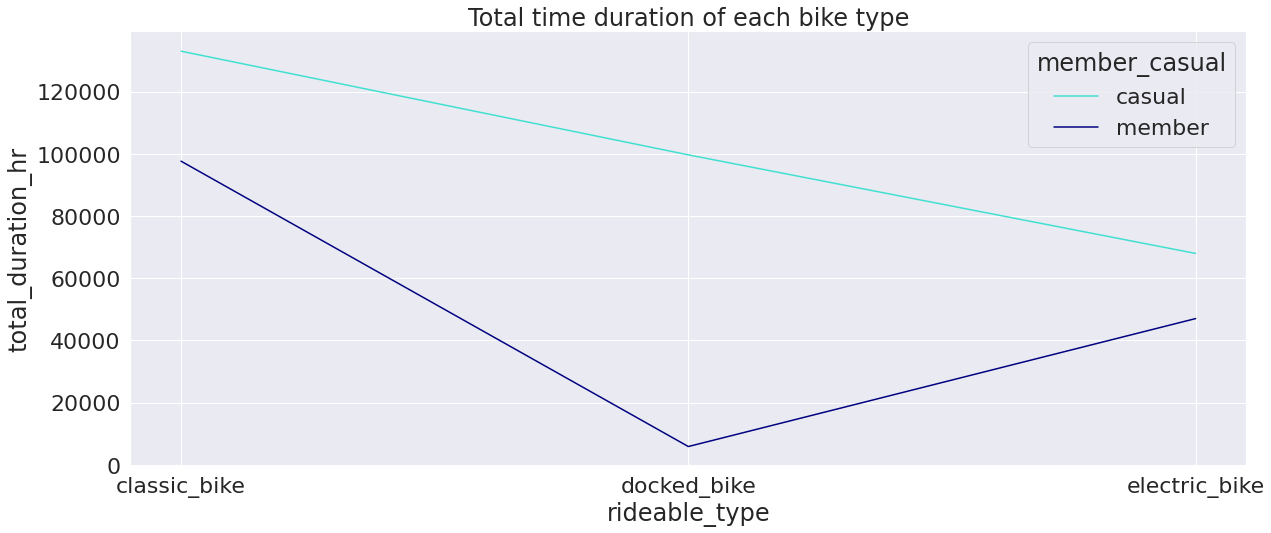

In [ ]:
# Plot total rides time duration from each station group by member and casual riders
plt.figure(figsize = (20,8))
ax = sns.lineplot(x="rideable_type", y = "total_duration_hr", hue="member_casual", palette = ['turquoise','navy'],
                  data=bikety_time).set_title("Total time duration of each bike type")
plt.show()

Q. Which bike types are popular from each stations?

Members prefer classic bikes from top 100 stations and its same for casuals rides also. Docked bikes are also prefered for casual rides from 

In [ ]:
# Total rides from each station group by member and casual riders
station_bty_count= pd.DataFrame(df.groupby(['rideable_type','member_casual', 'start_station_name' ],as_index =False).size().sort_values(by = 'size',ascending=False))

station_bty_count.head()

In [ ]:
# bike types popular from  top 100 by casuals and members
fig = px.bar(station_bty_count.groupby('member_casual').get_group('casual').head(100), x="size", y ="start_station_name", 
             color="rideable_type", facet_col="member_casual", orientation= 'h', color_discrete_sequence = ['aqua','magenta','darkgoldenrod'],
             title = 'Bike types popular from  top 30 by casuals rides',
             width = 1200, height = 600)

fig1 = px.bar(station_bty_count.groupby('member_casual').get_group('member').head(100), x="size", y ="start_station_name", 
              color="rideable_type", facet_col="member_casual", orientation= 'h',color_discrete_sequence = ['aqua','magenta','darkgoldenrod'],
             title = 'Bike types popular from top 30 stations by members',
              width = 1200, height = 600)
fig.show()
fig1.show()

In [ ]:
# Total rides duration from each station on specific bike by member and casual riders
station_bty_time= pd.DataFrame(df.groupby(['rideable_type','member_casual', 'start_station_name' ],
                                          as_index =False)['total_duration_hr'].sum().sort_values(by = 'total_duration_hr',ascending=False))

station_bty_time.head(5)

In [ ]:
# Plot total rides duration from each station on specific bike by member and casual riders
fig = px.bar(station_bty_time.groupby('member_casual').get_group('casual').head(100), x="total_duration_hr", y ="start_station_name",
             color="rideable_type", facet_col="member_casual", orientation= 'h', color_discrete_sequence = ['dodgerblue','lightgreen','violet'],
             title = ' Total rides duration from top 20 stations on specific bikes by casuals')

fig1 = px.bar(station_bty_time.groupby('member_casual').get_group('member').head(100), x="total_duration_hr", y ="start_station_name", 
              color="rideable_type", facet_col="member_casual", orientation= 'h', color_discrete_sequence = ['dodgerblue','lightgreen','violet'],
             title = 'Total rides duration from top 20 stations on specific bike by members')
fig.show()
fig1.show()

Q. Compare the number of trips made per month between members and casuals.

In month of May, june, july, august, september and october total ride count and total duration of rides are more campare to other months.

In [ ]:
# Count total rides each month by casuals and members
month_df_count = pd.DataFrame(df.groupby(['member_casual','month','month_name'],as_index =False).size())
      
month_df_count.head()

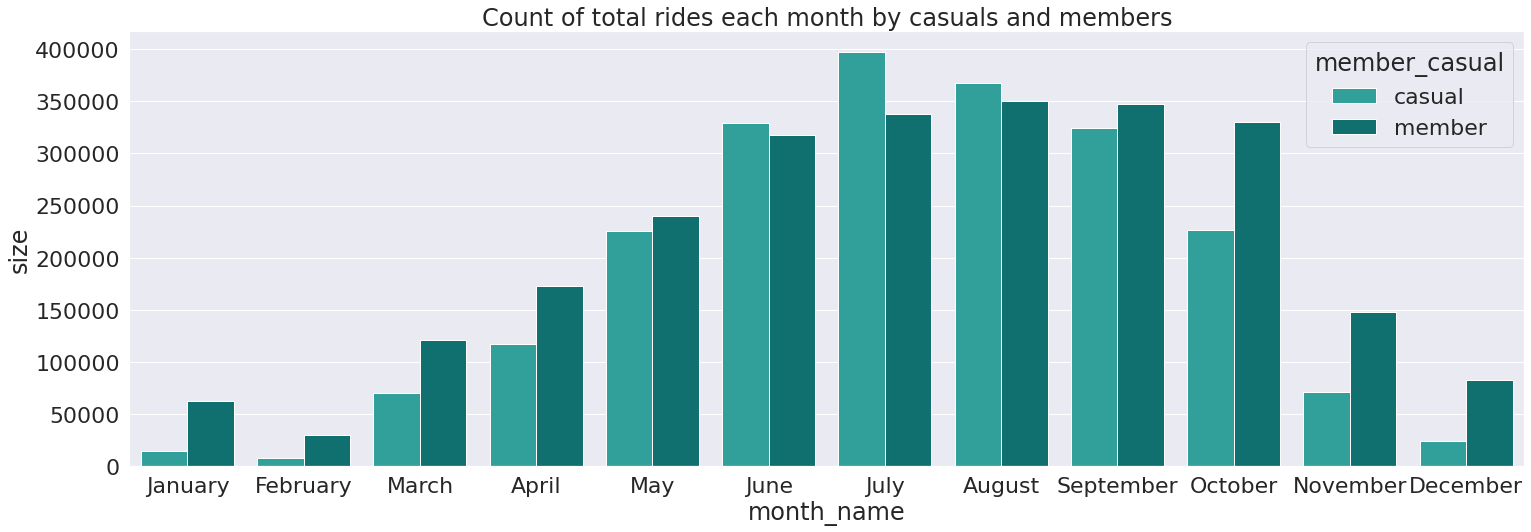

In [ ]:
# Plot Count total rides each month by casuals and members
plt.figure(figsize = (25,8))

ax = sns.barplot(x= "month_name", y = "size", hue="member_casual", palette= ['lightseagreen','teal'],
                 data=month_df_count).set_title("Count of total rides each month by casuals and members")

plt.show()

In [ ]:
# Total rideing time in each month by casuals and members
month_df_time = pd.DataFrame(df.groupby(['member_casual','month','month_name'],as_index =False)['total_duration_hr'].sum())
month_df_time.style.background_gradient(cmap ='viridis')\
        .set_properties(**{'font-size': '15px'})

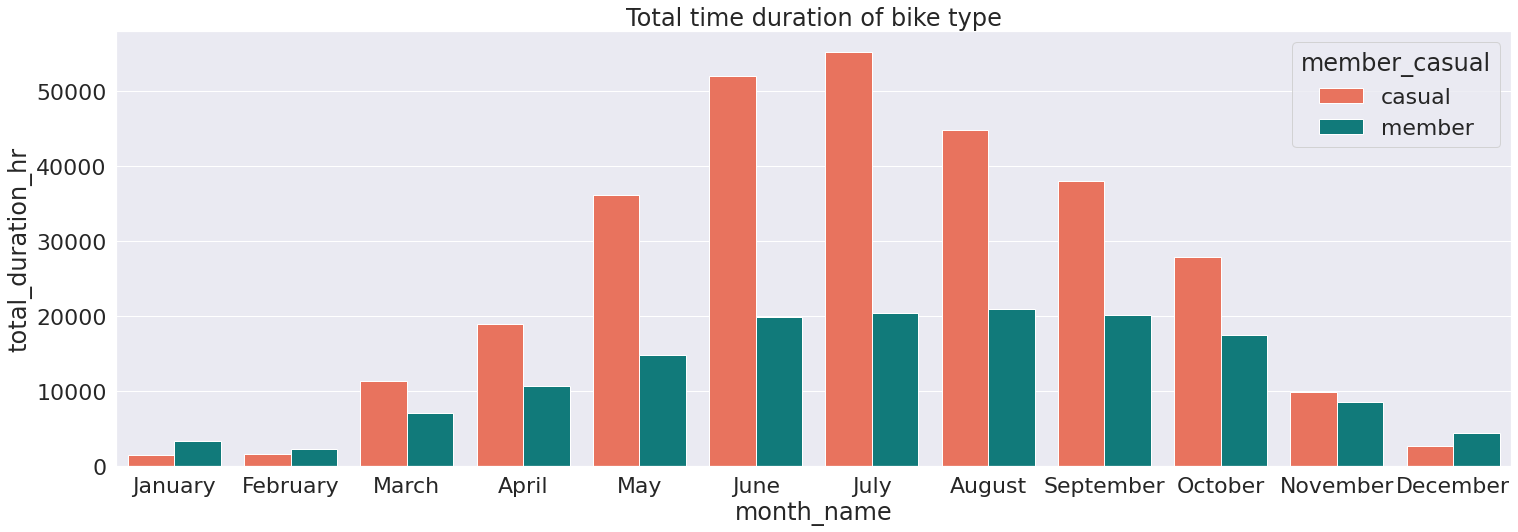

In [ ]:
# Plot Total rideing time in each month by casuals and members
plt.figure(figsize = (25,8))
# figure size in inches
ax = sns.barplot(x="month_name", y = "total_duration_hr", hue="member_casual", palette= ['tomato','darkcyan'],
                 data=month_df_time).set_title("Total time duration of bike type")
plt.show()

Q. Which bike types are prefered each month by members and casuals?

Both members and casuals prefer classic and electric bikes. Only in month of November and little bit in December members prefer docked bike. Total number of rides on docked bike by casuals are almost 1/4 of electric  bike and 1/6 of classic bikes.  

In [ ]:
# Count prefered bike types each month by casuals and members
month_bkty_count = pd.DataFrame(df.groupby(['member_casual','month','month_name','rideable_type'],as_index =False).size())

month_bkty_count.head(10)

In [ ]:
# Count prefered bike types by casuals and members  each month
px.bar(month_bkty_count, x="month_name", y ="size", color="rideable_type", facet_col="member_casual",
       title = ' Count prefered bike types by casuals and members  each month')

fig.show()

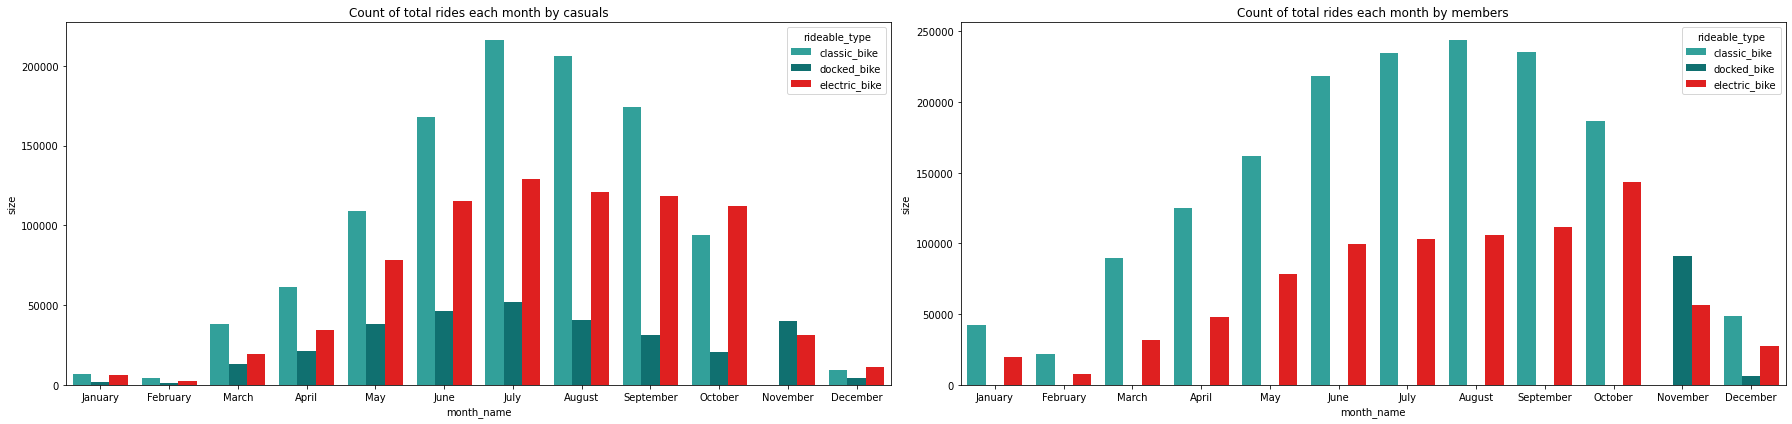

In [ ]:
# Plot Count total rides each month by casuals and members
plt.rcParams["figure.figsize"] = [25, 6]
plt.rcParams["figure.autolayout"] = True
f, axes = plt.subplots(1, 2)

#plt.figure(figsize = (25,9))
sns.barplot(x= "month_name", y = "size", hue="rideable_type", palette= ['lightseagreen','teal','red'], ax=axes[0],
                 data=month_bkty_count.groupby('member_casual').get_group('casual')).set_title("Count of total rides each month by casuals")

# Plot Count total rides each month by casuals and members
#plt.figure(figsize = (20,6))
sns.barplot(x= "month_name", y = "size", hue="rideable_type", palette= ['lightseagreen','teal','red'], ax=axes[1],
                 data=month_bkty_count.groupby('member_casual').get_group('member')).set_title("Count of total rides each month by members")

plt.show()


In [ ]:
# Total time of each bike per month
month_bkty_time = pd.DataFrame(df.groupby(['member_casual','month','month_name','rideable_type'],as_index =False)["total_duration_hr"].sum())
month_bkty_time.tail(10)

In [ ]:
# Count prefered bike types by casuals and members  each month
px.bar(month_bkty_time, x="month_name", y ="total_duration_hr", color="rideable_type", facet_col="member_casual",
       title = 'Total time of each bike per month')

fig.show()

Q. Compare trips made per week between members and casuals

From May's last week till septembers first week total rides count by casuals was significantly more than members. Rest of the year members total rides count are more than casuals.

The total time duration of casuals was significantly more than members from march last week till october second week. 




In [ ]:
# Total rides in each week by casuals and members
week_count = df.groupby(by = ['member_casual','week_start'],as_index =False)['total_duration_hr'].size()
#week_date_df.sort_values(by = 'total_duration_hr', ascending=False)
week_count.head() 

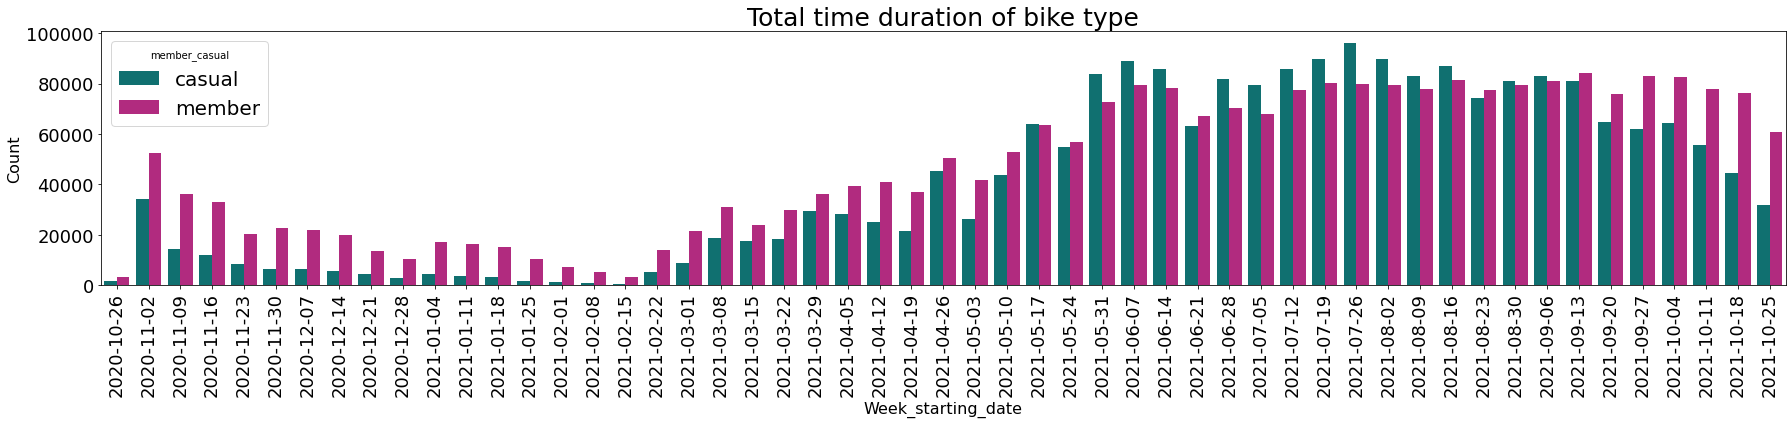

In [ ]:
# Plot total rides in each week by casuals and members
plt.xticks(rotation = 90)

# figure size in inches
rcParams['figure.figsize'] = 30,8
ax = sns.barplot(x="week_start", y = "size", hue="member_casual", palette = ['teal','mediumvioletred'], 
                 data=week_count).set_title("")

#modify individual font size of elements
plt.legend(title='member_casual', fontsize=20)
plt.xlabel('Week_starting_date', fontsize=16);
plt.ylabel('Count', fontsize=16);
plt.title('Total time duration of bike type', fontsize=25)
plt.tick_params(axis='both', which='major', labelsize=18)

plt.show()

In [ ]:
# Total rideing time in each week by casuals and members
week_df_time = df.groupby(by = ['member_casual','week_start'],as_index =False)['total_duration_hr'].sum()
#week_date_df.sort_values(by = 'total_duration_hr', ascending=False)
week_df_time.head() 

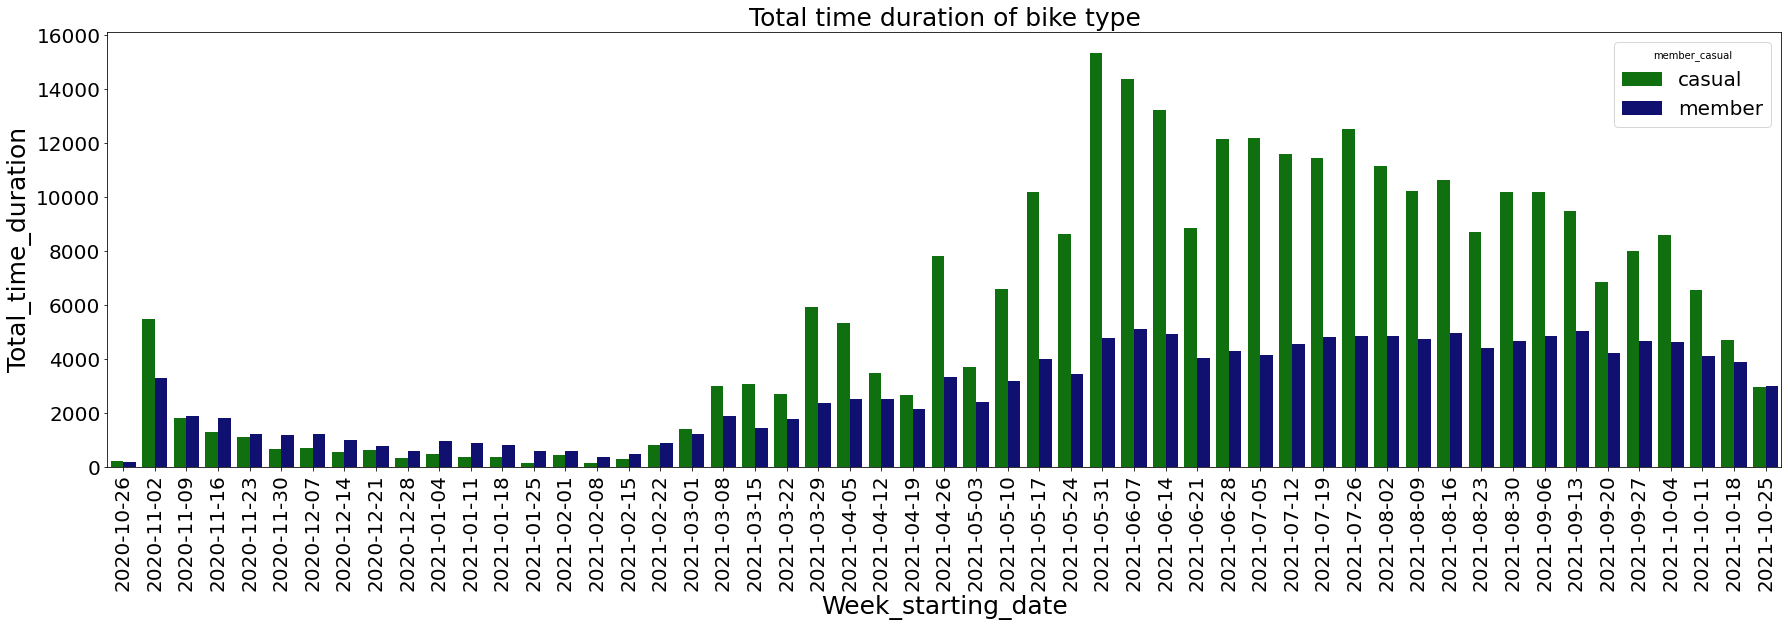

In [ ]:
# Total rideing time in each week by casuals and members
plt.xticks(rotation = 90)
rcParams['figure.figsize'] = 30,8

ax = sns.barplot(x="week_start", y = "total_duration_hr", hue="member_casual", palette = ['green','navy'],
                 data=week_df_time).set_title("Total rideing time in each week by casuals and members")

#modify individual font size of elements
plt.legend(title='member_casual', fontsize=20)
plt.xlabel('Week_starting_date', fontsize=25);
plt.ylabel('Total_time_duration', fontsize=25);
plt.title('Total time duration of bike type', fontsize=25)
plt.tick_params(axis='both', which='major', labelsize=20)

plt.show()

In [ ]:
# Total rides in each week by casuals and members
week_bkty_count = df.groupby(by = ['member_casual','week_start','rideable_type'],as_index =False)['total_duration_hr'].size()
week_bkty_count.head() 

In [ ]:
# Plot total rides in each week by casuals and members
fig = px.bar(week_bkty_count, x="week_start",y = "size", color="rideable_type", facet_col="member_casual",
             title = 'total rides in each week by casuals and members')

fig.show()

Q. Compare the number of trips made per hour between members and casuals.

17 hour is most basy hour of the day through out year for both casuals ans members.  Rides count by members are more during 17th hour but total riding time of casuals are more during that hour.

we can observe from morning 10 till evening 7 there are more than 1 lakh rides


In [ ]:
# hour wise total count
hour_df_count = df.groupby(['member_casual','hour_of_day'],as_index =False)['total_duration_hr'].size()
hour_df_count.head()

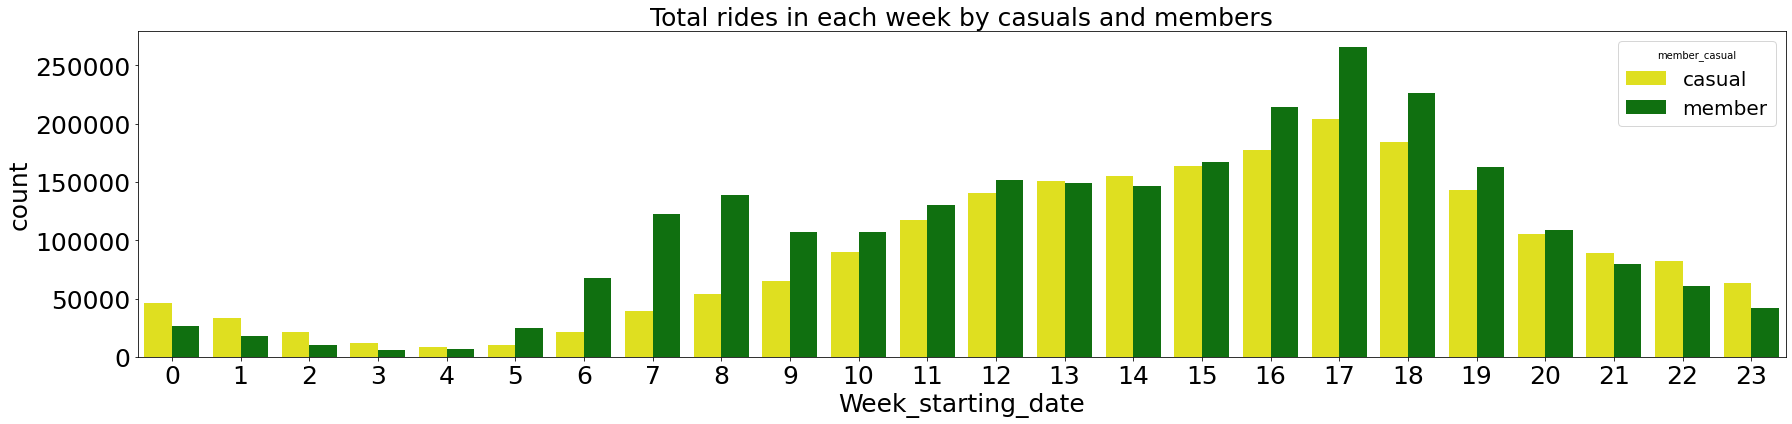

In [ ]:
# Total rides in each week by casuals and members
plt.rcParams["figure.figsize"] = [25, 6]

ax = sns.barplot(x="hour_of_day", y = "size", hue="member_casual", palette = ['yellow','green'], 
                 data=hour_df_count).set_title("Total rides in each week by casuals and members")

#modify individual font size of elements
plt.legend(title='member_casual', fontsize=20)
plt.xlabel('Week_starting_date', fontsize=25);
plt.ylabel('Ride Count in lakhs', fontsize=25);
plt.title('Total rides in each week by casuals and members', fontsize=25)
plt.tick_params(axis='both', which='major', labelsize=25)



In [ ]:
# hour wise total time duration
hour_time = df.groupby(['member_casual','hour_of_day'],as_index =False)['total_duration_hr'].sum().sort_values(by = 'total_duration_hr', ascending=False)
hour_time.head()

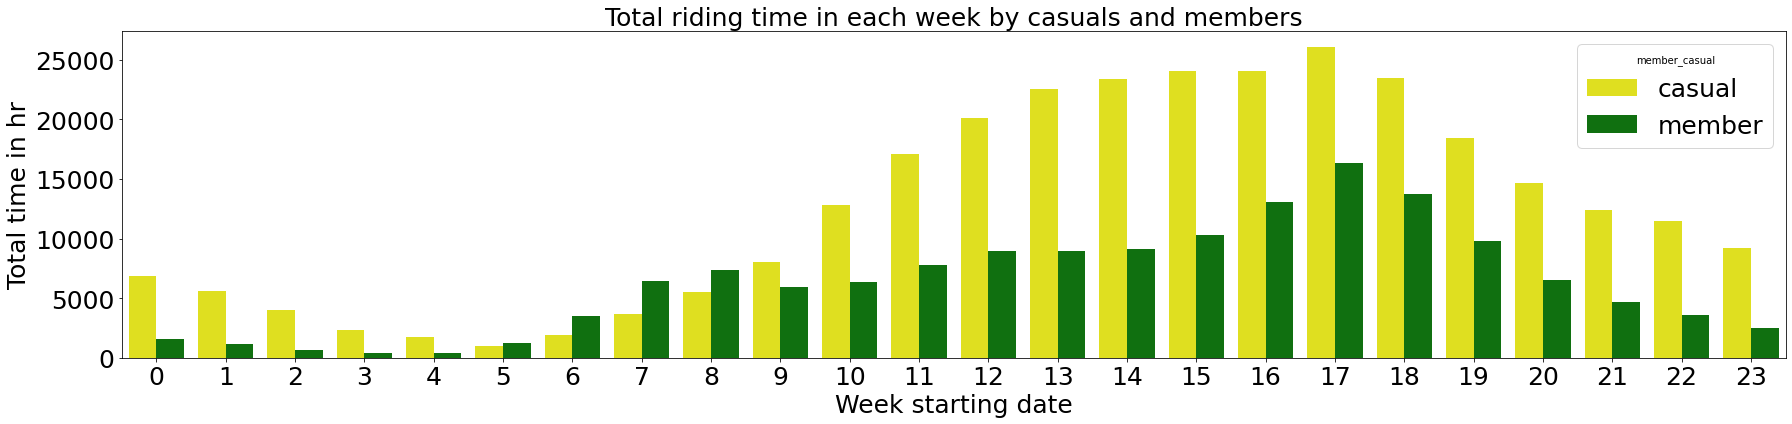

In [ ]:
# Total rideing time in each week by casuals and members
plt.rcParams["figure.figsize"] = [25, 6]

ax = sns.barplot(x="hour_of_day", y = "total_duration_hr", hue="member_casual", palette = ['yellow','green'],
                 data=hour_time).set_title("Total riding time in each week by casuals and members")

#modify individual font size of elements
plt.legend(title='member_casual', fontsize=25)
plt.xlabel('Week starting date', fontsize=25);
plt.ylabel('Total time in hr', fontsize=25);
plt.title('Total riding time in each week by casuals and members', fontsize=25)
plt.tick_params(axis='both', which='major', labelsize=25)

plt.show()